### The following is from [HERE](https://geographicdata.science/book/notebooks/11_regression.html), then modified as the example is worked through

## Spatial Regression
Regression (and predicion more generally), provides us a perfect case to examine how spatial structure can help us inderstand and analyze our data. In this chaprer we discuss how spatial structure can be used to both validate and imprive predicion algorithms, ficusing on linear regression speciffically. 

### What is spatial regression and why should I care?

Usually, Spatial structure helps regression models in one of two ways, The first (and most clear) way space can have an impact on our data is when the process *generating* the data is itself inherently spatial. Here, thisk of somthing like the prices ofr a single family home. It;s often the case that individuals pay a premiium on their house price in order to live in a better school district for the same quality house. Alternativly, homes closer to noie or chemical polluters like waste watter tretment plants, recycling facilities, or wide highways, may actuallu be cheaper than we would otherwise anticipate. In cases like aethma incidence, the locations individuals tend to travel to throughout the day - such as their work of areas of recreation- mau have more of an impact on their health than their given residential address. In this case, it may be necessary to use the data *from other sites* to predict the asthema incidence at a given site. Regardless of the specific case at play here, *geography is a feature*: it directly helps us make predictions about outcomes *because the outcomes are obtained from a geographical process*

An alternative (and more skeptical understanding) reluctantly acknoledged geography's instrumental value. Often, in the analysis of predictive methods and classifiers, we are interested in analyzing what we get wrong. This in common in econometrics; an analyst may be concerned that the model *systematically* mis-predicts somme types of observations. If we know our model routinely performs poorly on a known set of observations or type fo input, we might make a better model if we can account for this. Among other kinds of error diagnostics, geography provides us with an explicitly useful embedding to assess structure in our errors. Mapping classification/prediction error can help us show whether or not there are *clusters of error* in our data. If we *know* that errors tend to be larger in some areas than other areas (or if error is "contigious" between observations), then we might be able to exploit this structure to bake better predictions. 

Spatial structure in our errors might arise from when geography *should be* an attribute somehow, but we are not sure exactally how to include it in our model. THey may also arise because there is some *other* feature whose omission causes the spatial patterns in the error we see. If this additional feature were included, the structure would disapper. Or, it might arise from the complex interactions and interdependencies between the features that we have chosen as predictors., resulting in an intrinsic structure in mis-prediction. Most of the predictors we use in models of social processes contain *embodied* spatial information: patterning ontrinsic to the feature that er get for free in the model. If we intend to or not, using a spatailly patterened predictor in a model can result in spatially patterned errorsl using more thatn one can amplify this effect. Thus, *regardless of whether or not the true preocess is explicitly geographic*, additional information about the spatial relationships between our observations or more information about nearby sites can make our predictions better. 

In this notebook, we build space into the traditional regression framework. We begin with a standard linear regression model, devoid of andy geographical reference. From there, we formalize space and spatial relationships in three main ways: 
* encoding it in exogenous variables
* through spatial heterogeneity, or as systematic variation of outcomes across space
* as dependence, or through the effect associated th the characteristics of spatial neighbors.
  
Throughout, we focus on the conceptual difffernces each approach entails rather than on the technical details. 

In [8]:
from pysal.lib import weights
from pysal.explore import esda
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily

### Data: San Diego Airbnb

To learn a little about how regressoin works, we'll examine information about Airbnb properties in San Diego, CA. THis dataset contains house intrinsic charateristics, both continious (number of beds as in beds) and categorical (type of renting, of, in Airbnb jargon, property group as in the series of pg_X binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, d2balboa or neighborhood id, neighborhood_cleansed)

In [2]:
db = gpd.read_file("../data/air_bnb/regression_db.geojson")

These are the explanatory variables we will use throughout the notebook

In [3]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

### Non-Spatial Regression, A (Very) Quick Refresh

Before we discuss how to explicitly include space into the linear regression framework, lwt us show how basic regression can be carried out in Python, and how on can begin to interperate the results. By no means is this a formal and complete introduction to regtrsion, so if that is what you are looking for see [GH06](https://doi.org/10.1017/cbo9780511790942) (in particular chapters 3 and 4, which provide a fantastic, non-spatial introduction).

The core idea of linear regression is to explain the variation in a given (*dependent*) variable as a linear function fo a collection of other (*explanatory*) variables. For example, in our case, we may want to express the price of a house as a finction of the number of bedroome it has and whether it is a condominium or not. At the individual level, we express this as:

$P_i = \alpha + \sum\limits_{k}\bf{X}_{ik}\beta_k + \epsilon_{i}$

where $P_i$ in the Airbnb price of house $i$ and $\bf{X}$ is a set of covariates that we use to explain such price (e.g., No. of bedrooms and condominium binary variable). $\beta$ is a vector of parameters that give us information about in which way (e.g., increases price, decreases) and to what extent (e.g., var_a is responsible for 20% of price), $\alpha$ is a constant term that explains the average price of a house with all other variable set to zero. The term $\epsilon_{i}$ is an error term and captures elemente that influence the price of a house not included in $\bf{X}$, We can also express this relation in matrix form, excluding sub-indicies for $i$, which yields:

$P = \alpha + \bf{X}\beta + \epsilon$

A regression can be seen as a multivariate extention fo bivariate cerrelations. Indeed one way to interpreate the $\beta_{k}$ coefficents in the equation above is as the degree of correlation between the explanatory variable $k$ and the dependent variable, *keeping all the other explanatory variables constant*. Whrn one calculates bivatiate correlations, the coefficent of a variable is picling up the forrelation between the variables, but it is also subsuming into it the variation associates eith other correlated variables - also called confounding factors. Regression allows us to isolate the distinct effect that a single variable can have on the dependent one, once we *control* for those other variables. 

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g., statsmodels, scikit-learn, pysal). We will import the spreg module in Pysal:

In [4]:
from pysal.model import spreg

In the context of this notebook it makes sense to start with spreg, as that is the only library that will allow us to move into explicitly spatial econometric models. To fit the model specified in the equation above with $\bf{X}$ as the list defined, using ordinary least squares (OLS), we need only the following lien of code: 

In [6]:
# Fit the OLS model
m1 = spreg.OLS(
               db[["log_price"]].values,   # Dependent variable
               db[variable_names].values,  # Independent variables
               name_y="log_price",         # Dependent variable name
               name_x=variable_names,      # Independent variable names
              )

We use the command OLS, part of the spreg sub-package, and specify the dependent variable (the log of the price, so we can interpret results in terms of percentage change) and the explanatory iones. Note that both objects need to be arrays, we we extract them from the pandas dataframe object with .values.

In order to inspect the results of the model, we print the summary attribute:

In [7]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

A full detailed explanation of the output is beyond the scope of this notebook, so we ficus on the televant bits for our main purpose. The focus will be on the Coefficente section, which gives us the estimates for $\beta_{k}$ in our model. In other words, these numbners express the relationship between each explanatory variable and the dependent one, once the effict of confounding variables has been accounted for. Keep in mind that regression is no magic; we are only dicounting the effect of confounding factors that we include in the model, not of *all* potintially confounding factors.

Results are largely ase expected: houses tend to be significantaly more expensive if they accomodate morte people (variable accomodates), if they have more bathrooms and bedrooms, and if they are a condominium or part of the "other" category of house type. Conversly, given a number of rooms, houses with more beds (i.e., listings that are more "crowded") tend to go for cheaper, as it is the case for properties where one does not rent the entire house but only a room (variable rt_Private_room) or even shares it (variable rt_Shared_room). Of course, you might conceptually doubt the assumption that it is possible to *arbitrarily* change the number of beds within an Airbnb without eventually changing the number of people it accomodates, but methods to address these concerns using *interaction effects* won't be discussed here. 

### Hidden structures

In general, our modele peforms well, being able to predict slightly above two-thirds ($R^2 = 0.67$) of the variation in the mean nightly price using the covariates we've discussef above. But, our model might dispaly some clustering in the errors, which may be a problem as that violates the Independent and identically distributed (i.i.d) assumption that linear models ususally come built in with. To interrogate this, we can do a few things. One simple concept might be to look at the correlation between the error in predicting an Airbnb and  the error in predicting its nearest neighbor. To examine this, we might first want to want to split our data up by regions and see if we've got some spatial structure in our residuals. One reasonable theory might be that our model does not include any information about beaches, a critical aspect of why people live and vacation in San Diego. Therefore we might want to see whether of not our errors are higher or lower depending on whether a neighborhood is in a "beach" neighborhood - a neighborhood near the ocean. We use the code below to generate a visual representation of "beach" andd "no beach" neighborhoods.

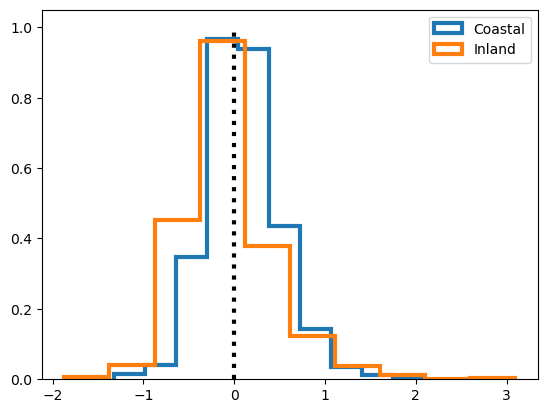

In [9]:
# Create a Boolean indicating if a property is coastal or not
is_coastal = db.coastal.astype(bool)

# Split our residuals (m1.u) between coastal and not
coastal_residuals = m1.u[is_coastal]
inland_residuals = m1.u[~is_coastal]

# Create a histogram of the distribution of coastal residuals
plt.hist(coastal_residuals, histtype="step", density=True, linewidth=3, label="Coastal")
# Creare a histogram of the distribution of inland residuals
plt.hist(inland_residuals, histtype="step", density=True, linewidth=3, label="Inland")

# Add a Line on x=0
plt.vlines(0,0,1,linestyle=":", color="k", linewidth=3)
# Add legend
plt.legend()
# Display
plt.show()

Whereas is appears that the neighborhoods on the coast have only slightly higher aveage errors (and have lower variance in their prediction errors), the two distributions are statistically significantly different from one another when compared with a classic $t$-test:

In [11]:
from scipy.stats import ttest_ind

ttest_ind(coastal_residuals, inland_residuals)

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

It is often better to use a straight-forward, data-driven testing and simulation methods rather than assuming the mathematical assumptions of the $t$-statistic are met. 

To do this, we can shuffle the assignments of coastal and inland to check whether or not there are differences in the distributions of the observed residual distibutions and random distributions. In this way, we shuffle the observations that are on the coast, and plot the resultind cumulative distributions. 

Below, we run 100 simulated re-assignments of districts to either "coast" or "inland", and compare the distributions of randomally assigned residuals to the observed distributions of residuals. Further, we do this plotting by the *emperical cumulative density function*, not the histogram directly. Thie is because the *emperical cumulative density function* is ususallly easier to examine visually, especially for subtle differences. 

The black lines represent our simulations, the colored patches below then represent the observes distribution of residuals (Figure 2). If the black lines tend to be on the left of the colored patch, then, the simulations (where prediction error is totally random with respect to our categories of "coastal" and "inland") tend to have more negative residuals than our actual model. If the black lines tend to be on the right, then they tend to have more positive residuals. As a refresher, positive residuals mean that our model is under-predicting, and negative residuals mean our model is over-predicting. Below, our eimulations provide direct evidence for the claim that our model may be systematically under-predicting coastal prices and over-predicting inland prices.

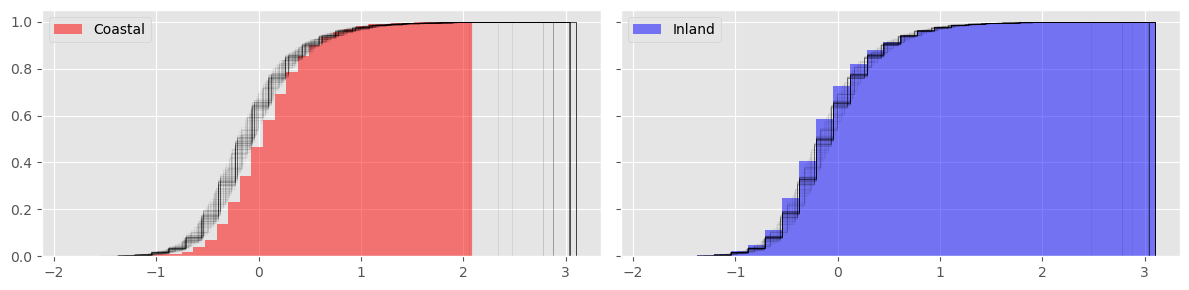

In [30]:
from matplotlib import style
plt.style.use('ggplot')

n_sim = 100      # Number of simulations to conduct

fig, axes = plt.subplots(1,2, figsize=(12,3), sharex=True, sharey=True)

axes[0].hist(
            coastal_residuals,
            color=["r"],
            alpha=0.5,
            density=True,
            bins=30,
            label="Coastal",
            cumulative=True,
          )

axes[1].hist(
            inland_residuals,
            color=["b"] ,
            alpha=0.5,
            density=True,
            bins=30,
            label="Inland",
            cumulative=True,
          )

for sim in range(n_sim):
    shuffled_residuals = m1.u[np.random.permutation(m1.n)]
    random_coastal = shuffled_residuals[is_coastal]
    random_inland = shuffled_residuals[~is_coastal]

    if sim == 0:
        label = "simulations"
    else:
        label=None
        axes[0].hist(
            random_coastal,
            color="k",
            alpha=0.05,
            density=True,
            histtype="step",
            bins=30,
            label=label,
            cumulative=True,
          )
        axes[1].hist(
            random_inland,
            color="k",
            alpha=0.05,
            density=True,
            histtype="step",
            bins=30,
            label=label,
            cumulative=True,
          )
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

Additionally, it may be the case that some neighborhoods are mre desireable thatn other neighborhoods due to unmodeled latent preferences or marketing. for instance, despite its procimity to the sea, living near camp Pendleton - A marine base in the northern part of the city - may incur fome significant penelties on area desirability due to noise and pollution. There are questions that domain knowledge privides and data analysis can help us answer. For us to determine whether or not this is the case, we may be interetef in the fill distribution fo model residuals within each neighborhood. 

To make this more clear, we'll first sort the neighborhoods by median residual in that neighborhood, and then make a boxplot (Figure 3), to examine the distribution of residuals in each neighborhood. 

/tmp/ipykernel_42514/1427596682.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


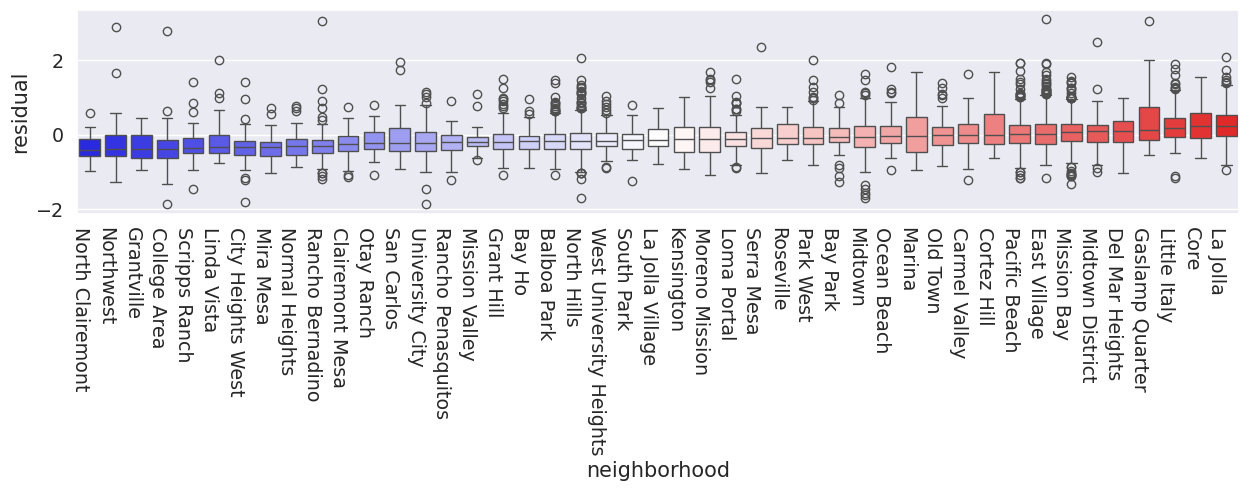

In [46]:
# Create column with resudual values from m1
db["residual"] = m1.u

# Obtain the median values of residuals for each neighborhood
medians = db.groupby("neighborhood").residual.median().to_frame("neighborhood_residual")

# Increase font size
sns.set(font_scale=1.25)

#set up fig
fig, ax = plt.subplots(1,1,figsize=(15,3))  # wo make subplots with one so we wn't need to call ax=plt.gca()

# Generate the boxplots from neighborhood distributions
sns.boxplot(
            x="neighborhood",
            y="residual",
            ax=ax,
            data = db.merge(
                            medians,
                            how="left",
                            left_on="neighborhood",
                            right_index=True)
                            .sort_values("neighborhood_residual"),
            palette="bwr",
           )
# Rotate the X labels for legibility
fig.autofmt_xdate(rotation=-90)
# Display
plt.show()


No neighborhood is disjoint from one another, but some do appear to be higher than others, such as the well-known downtown tourist neighborhood areas of the Gaslamp Quarter, Little Italy, or the Core. Thus, there may be a distinctive effect of intangible neighborhood fashionablness that matters in this model. 

Noting that many of the nost over - and under - predicted neighborhoods are near one another in the city. it may also be the case that there is some sort of *contagion* or spatial spillovers in the nightly rental price. This is often apperent when individuals seek to price their Airbnb listings to compete with other similar nearby listings. Since our model is not aware of this behavior, its errors tend to cluster. One exceponally simple way we can look into this structure is by examining the relationship betweeen an observeration;s residuals and its sorrounding residuals. 

To do this, we will use *spatial weights* rto represent the geographic relationship between observations. For this example, we'll start off with a $K N N$ matrix where $k = 1$, meaning we're focusing on the linkages of each Airbnb to their nearest other listing. 

In [48]:
knn = weights.KNN.from_dataframe(db, k=1)

/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


This means that, when we compute the *spatial lag* of that KNN weight and the rsidual, we get the residual of the Airbnb listing closest to eash observation. 

Text(0, 0.5, 'Spatial Lag of Model Residuals = $W u$')

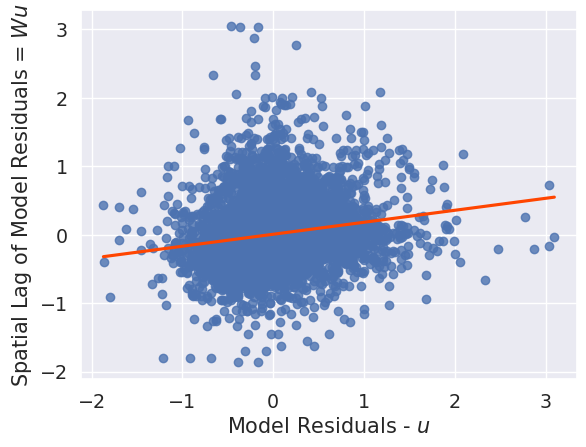

In [53]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)

ax = sns.regplot(
                 x=m1.u.flatten(),
                 y=lag_residual.flatten(),
                 line_kws={"color":"orangered"},
                 ci=None,
                )

ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals = $W u$")

We see that our prediceion errors tend to cluster (Figure 4)! Above, we show the relationshi[ between our prediceion error at each site and the prediciton error at the site nearest to it. Here we are using the nearest site to stand in for the *sorroundings* of that Airbnb. This means that. when the model tends to over-predict a given Airbnb's noghtly log proce, sites around that Airbnb are more liekly to *also be over predicted* An interesting property of this relationship is that it eneds to stabalize as the number of nearest neighbors used to construct each Airbnb's sorroundings increases. 

#### The K-neighbor correlogram
It may be the case that spatial dependence in our mispredictions onlu matters for sites that are extremly close to one another, and it decays with quickly with distance. To investicater this we can examine correlation between each sit's residual and the *average* of the $k$-th nearest neighbors' residuals, increasing $k$ until the estimate stabalizes. The main idea is central to the geospatial concept, the *correlogram*, whhich goves the correlation between sites of an attribute being studied as distance increases. 

One quick way to check whether or not what we've seen is *unique* to *significant* is to compare it to what happens when we just assign neighbors randomly. If what we observe is substantially different from what emereges when neighbors are random, then the structure of the neighbors embeds a structure in the residuals. We won't spend too much on this theory specifically, but er can quickly and efficiently compute the correlation between our observed residuals and the spatial lag of an increasing k-nearest neighbor set:

In [58]:
correlations = []
nulls = []

for order in range(1,51, 5):
    knn.reweight(k=order, inplace=True) #inplace operation, to avoid copies
    knn.transform="r"    #row standardization
    lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
    random_residual = m1.u[np.random.permutation(len(m1.u))]
    random_lag_residual = weights.spatial_lag.lag_spatial(knn, random_residual) #identical to random neighbors in KNN
    correlations.append(np.corrcoef(m1.u.flatten(), lag_residual.flatten())[0,1]) # Pearson correlation coefficents
    nulls.append(np.corrcoef(m1.u.flatten(), random_lag_residual.flatten())[0,1]) # Pearson forrelation coefficents


/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids

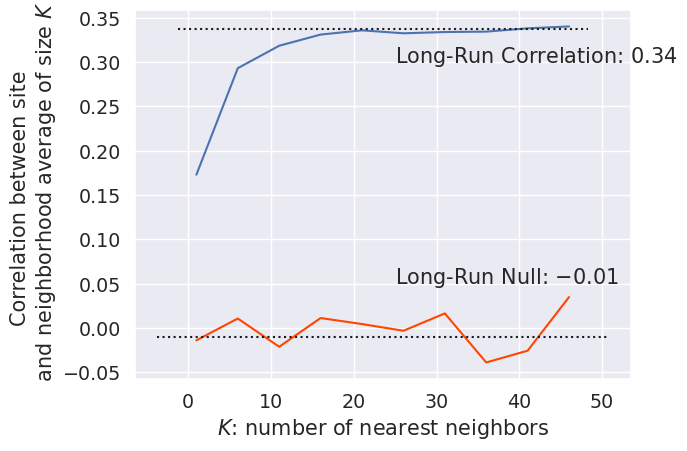

In [67]:
plt.plot(range(1,51,5), correlations)
plt.plot(range(1,51,5), nulls, color="orangered")
plt.hlines(np.mean(correlations[-3:]),
           *plt.xlim(),
           linestyle=":",
           color="k"
          )   #average of last three correlations we computed, where we expect it to stablaize
plt.hlines(np.mean(nulls[-3:]),
           *plt.xlim(),
           linestyle=":",
           color="k"
          )   #average of last three correlations we computed, where we expect it to stablaize
plt.text(
    s="Long-Run Correlation: ${:.2f}$".format(
        np.mean(correlations[-3:])
    ),
    x=25,
    y=0.3,
)
plt.text(
    s="Long-Run Null: ${:.2f}$".format(np.mean(nulls[-3:])),
    x=25,
    y=0.05,
)
plt.xlabel("$K$: number of nearest neighbors")
plt.ylabel(
    "Correlation between site \n and neighborhood average of size $K$"
)
plt.show()



Clearly these two curves are different. The observed correlation reaches a peak around $r = .34$ when around 20 nearest listings are used. Thie means that assing more than about 20 nearest neighbors does not significantally change the correlation in the residuals. Further, the lowest correlations is for the sinfle neares neighbor, and the correlation rapidly increases asmore neighbors are added close to the listing. This this means that there does appear to be an unmeasured spatial structure in the residuals, since they as more simmilar to one another when they are far near ve. far apart. Further, whereas it's not shown here (since computationally it becomes intracable), as the number of nearest nreighbors gets very large (approacjhing the number of observations in the dataset), the average of the $k$-th nearest neighbor's residuals goes to zero - which is the global average of the residuals. In other words, the correlation of the residuals and a vector that is nearly constant begins to approach zero, we have stablaized. 

The null correlations, however, use random chosen neighbors (without reassignment), This, since sampling is guarenteed to be random in this case, each average of $k$ randomly chosen neighbors is usually zero (or at least has a global mean of zero over a suitable number of itereations). So the correlation between the observed residual and the average of the $k$ randomly chosen residuals is also usually zero, This, increasing the number of randomly chosen neighbors does not significantly adjust the long-run average of zero. Taken together we can conclude that there is distinct postitive spatial dependence in the error, This means that our over- and under-predictions are likely to cluster.